# Research Question: To what extent is food security, a basic need, through SNAP associated with mass shootings gun violence in the United States?

# Overview

The Second Amendment guarantees individual gun ownership, as affirmed by landmark rulings like *District of Columbia v. Heller* (2008). Yet, gun violence remains a significant U.S. mortality cause. Realizing the tension between rights and violence,and knowing better basic need support can forester social stability, we are interested  to explore if access to basic food benefits, provided by the **Supplemental Nutrition Assistance Program (SNAP)**, influences gun violence rates (specifically mass shootings). We hypothesize that basic food security through SNAP fosters societal stability and reduces gun violence.

Our study focuses on the **2017 to 2019 timeframe** to capture conditions before and after *the 2018 Farm Bill* making changes to SNAP and to avoid COVID-19 impacts. We'll examine **mass shootings**, including public, bar/club incidents, family annihilations, drive-bys, and others with at least four victims shot, encompassing mass murder by firearms.

Accordingly, we operationalize the research question as follows. The **outcome variable** of the research is *mass shooting gun violence rate, measured by computing the proportion of mass shooting victims  — both injured and died — to the total population*. Our **independent variable** is SNAP benefit, which we measure as *the ratio of the average number of people participating in SNAP to the total population*. We recognize that there may be an additional variable, household income — if a household is below the poverty line — that may also affect gun violence. For example, counties with a high average household income might have fewer homicides and injuries from gun violence even if they do not have a high use of food through SNAP. Our research targets each state and is at the county level.

# Project EDA

## Applicability of the Data to the Research Question

The outcome variable in our study is the mass shooting gun violence rate in each county. We sourced this data from the Gun Violence Archive, which specifically tracks various forms of gun violence and includes data for each State and County. For this project, we select mass shootings.


Our independent variable is SNAP benefits usage. We measure the total public and non-public assistance cases in each county.  This data also includes demographic information —  age, race, sex, income, and educational attainment — that may be helpful. To standardize this data, we'll calculate the proportion of the population accessing SNAP relative to the total population from 2017 to 2019, using data from the U.S. Census and SNAP's official records. This approach ensures a standardized comparison across diverse county populations. Both datasets contain County, State, and Year, facilitating data merging and analysis relevant to our research question.

## Dependencies
Import all required libraries.

In [551]:
import os
import io
import json
from pathlib import Path
import requests
from tabulate import tabulate
from IPython.display import IFrame
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium
from folium.plugins import HeatMap, HeatMapWithTime
from shapely import wkt
import branca
from branca.colormap import linear
import branca.colormap as cm
import sklearn.linear_model as linear
import sklearn.metrics as metrics
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    cross_val_score, 
    cross_val_predict, 
    GridSearchCV
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import (
    r2_score, 
    accuracy_score, 
    roc_curve, 
    auc, 
    classification_report, 
    mean_absolute_error, 
    mean_squared_error, 
    confusion_matrix, 
    roc_auc_score,
    recall_score,
    precision_score
)
import statsmodels.api as sm

# Data
All data is collected for the years 2017-2019 to more clearly examine the effects of SNAP on gun violence without the factor of COVID-19. The Gun Violence Archive changes the number of sources after 2019, which can also affect results. The 2017-2019 range provides the most consistent set of data prior to COVID-19.

### Gun Violence Data
Mass shooting data (2017-2019) retrieved from the Gun Violence Archive.

In [552]:
# Load in gun violence data
mass_shootings_2017 = pd.read_csv('data/mass_shootings_2017.csv')
mass_shootings_2018 = pd.read_csv('data/mass_shootings_2018.csv')
mass_shootings_2019 = pd.read_csv('data/mass_shootings_2019.csv')
gun_violence_data = pd.concat([mass_shootings_2017, mass_shootings_2018, mass_shootings_2019], axis=0).drop_duplicates()

### City and Census Data
City data is needed to map cities to counties, and the US Census Burea's data on poverty status provides other demographic information by county.

In [553]:
# Load in city and census data
city_data = pd.read_csv('data/uscities.csv')[['city', 'state_name', 'county_name', 'population', 'density']] #https://simplemaps.com/data/us-cities
us_census_data_2017 = pd.read_csv('data/us_census_data_2017.csv')
us_census_data_2018 = pd.read_csv('data/us_census_data_2018.csv')
us_census_data_2019 = pd.read_csv('data/us_census_data_2019.csv')

### SNAP Data
SNAP data is used to analyze the usage per county.

In [554]:
# Load in SNAP data
snap_data_2017 = pd.read_excel('data/snap_data_jan_2017.xls', header=0)
snap_data_2018 = pd.read_excel('data/snap_data_jan_2018.xls', header=0)
snap_data_2019 = pd.read_excel('data/snap_data_jan_2019.xls', header=0)

# Data Cleaning

### Gun Violence Data

In [555]:
### CLEANING: gun violence data ###

# Text cleaning city or county names
gun_violence_data['City Or County'] = gun_violence_data['City Or County'].str.replace(r' \(.*?\)', '', regex=True)

# Map cities to counties
gun_violence_data = pd.merge(gun_violence_data, city_data, left_on='City Or County', right_on='city', how='left')
gun_violence_data.drop(['City Or County', 'city', 'state_name', 'population', 'density'], axis=1, inplace=True)
gun_violence_data.insert(4, 'County', gun_violence_data.pop('county_name'))

# Filter by year (target: 2017-2019)
gun_violence_data.insert(2, 'Year', gun_violence_data['Incident Date'].apply(lambda x: int(x.split(', ')[1])))
gun_violence_data = gun_violence_data[(gun_violence_data['Year'] >= 2017) & (gun_violence_data['Year'] <= 2019)]
gun_violence_data

# Remove columns
# (Operations is N/A only, Address is too granular)
gun_violence_data.drop(columns=['Operations', 'Address'], inplace=True)

In [556]:
# Check for null values
nulls = gun_violence_data.isnull().mean()

In [557]:
# Handle null values
gun_violence_data = gun_violence_data.dropna(subset=['County'])
no_nulls = gun_violence_data.isnull().mean()

In [558]:
# Create a column "Victims", which is calculated through "Victims Killed" + "Victims Injured"
gun_violence_data['Victims'] = gun_violence_data['Victims Killed'] + gun_violence_data['Victims Injured']

### US Census Data

**NOTE:** _Some feature selection happens in this section of cleaning -- the initial features of interest are directly selected from the dataset._

In [559]:
### CLEANING: US census data ###
us_census_data_2017['Year'] = [2017] * len(us_census_data_2017)
us_census_data_2018['Year'] = [2018] * len(us_census_data_2018)
us_census_data_2019['Year'] = [2019] * len(us_census_data_2019)

# Make dataframe with census data from all years
us_census_data = pd.concat([us_census_data_2017, us_census_data_2018, us_census_data_2019], ignore_index=True)

# Select desired columns: geographic area name, total estimate population, below poverty level population, percent below poverty level,
# In addition to other columns related to race, sex, age group, educational attainment, employment status, and work experience
interest_column_to_name = {
    'NAME': 'County, State',
    'Year': 'Year',
    'S1701_C01_001E': 'Total Population',
    'S1701_C02_001E': 'Below Poverty Level',
    'S1701_C03_001E': 'Percent Below Poverty Level',
    'S1701_C01_058E': 'Mean Income Deficit',
    'S1701_C01_060E': 'Worked Less Than Full Time',
    'S1701_C01_027E': 'LABOR: Total Civilian Labor Force',
    'S1701_C01_028E': 'LABOR: Employed',
    'S1701_C01_031E': 'LABOR: Unemployed',
    'S1701_C01_022E': 'EDUCATION: Age 25+ Educated Total Population',
    'S1701_C01_023E': 'EDUCATION: Less Than High School',
    'S1701_C01_024E': 'EDUCATION: High School',
    'S1701_C01_025E': 'EDUCATION: College or Associates',
    'S1701_C01_026E': 'EDUCATION: Bachelors or Higher',
    'S1701_C01_013E': 'White',
    'S1701_C01_014E': 'Black / African American',
    'S1701_C01_015E': 'American Indian and Alaska Native',
    'S1701_C01_016E': 'Asian',
    'S1701_C01_017E': 'Native Hawaiian and Other Pacific Islander',
    'S1701_C01_018E': 'Other Race',
    'S1701_C01_020E': 'Hispanic or Latino',
    'S1701_C01_003E': 'AGE: Under 5',
    'S1701_C01_004E': 'AGE: 5 to 17',
    'S1701_C01_007E': 'AGE: 18-34',
    'S1701_C01_008E': 'AGE: 35-64',
    'S1701_C01_010E': 'AGE: 65 and older',
    'S1701_C01_011E': 'Male',
    'S1701_C01_012E': 'Female'
}

# Replace codes with column names
us_census_data = us_census_data[interest_column_to_name.keys()].iloc[1:]
us_census_data.rename(columns=interest_column_to_name, inplace=True)

# Clean County, State data (has some data that is not county-level)
us_census_data = us_census_data[us_census_data['County, State'].str.contains(',', na=False)]

# Separate County and State
us_census_data.insert(1, 'County', us_census_data['County, State'].apply(lambda x: x.split(', ')[0]))
us_census_data['County'] = us_census_data['County'].replace(' County$', '', regex=True)
us_census_data.insert(2, 'State', us_census_data['County, State'].apply(lambda x: x.split(', ')[1]))
us_census_data.drop(['County, State'], axis=1, inplace=True)

# From documentation, entries that are 'N' indicate that data for this geographic area
# Cannot be displayed because the number of sample cases is too small. Replace these values with 0.
us_census_data.replace('N', 0, inplace=True)

# Change all values to numeric (all objects currently)
exclude = ['County', 'State']
for column in us_census_data.columns:
  if not column in exclude:
    us_census_data[column] = pd.to_numeric(us_census_data[column])

In [560]:
# Check for null values
nulls = us_census_data.isnull().mean()

### SNAP Data

In [561]:
### CLEANING: SNAP data - HELPER FUNCTION for partial cleaning ####

def clean_snap_data(dataset):

  # Drop the last 3 columns because they are "U.S. Summary", NaN, NaN
  dataset.drop(dataset.tail(3).index, inplace=True)

  # Extract the state abbreviation, change it to state name, create new column 'State'
  pattern = r'\d{7}\s([A-Z]{2})'
  state_names_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
  }
  matches = dataset['Substate/Region'].str.extract(pattern)
  matches.columns = ['State Abbreviation']
  dataset['State'] = matches['State Abbreviation'].map(state_names_mapping)

  # Extract the county, create new column 'County'
  def extract_county_name(string):
      return string.split(' ')[3]
  dataset['County'] = dataset['Substate/Region'].apply(extract_county_name)

  # Change county -> "AUTAUGA" to "Autauga"
  def capitalize_county(county):
      return county.capitalize()
  dataset['County'] = dataset['County'].apply(capitalize_county)

  dataset.drop(['Substate/Region'], axis=1, inplace=True)

  # Convert strings to values
  exclude = ['State', 'County']
  for column in dataset.columns:
    if not column in exclude:
      dataset[column] = pd.to_numeric(dataset[column], errors='coerce').fillna(0)

  return dataset

In [562]:
# Clean snap datasets using function above
snap_data_2017 = clean_snap_data(snap_data_2017).assign(Year=2017)
snap_data_2018 = clean_snap_data(snap_data_2018).assign(Year=2018)
snap_data_2019 = clean_snap_data(snap_data_2019).assign(Year=2019)

# Make dataframe with snap data from all years
snap_data = pd.concat([snap_data_2017, snap_data_2018, snap_data_2019],
                      ignore_index=True).groupby(['State', 'County', 'Year']).agg('sum').reset_index()

In [563]:
# Check for null values
null_proportions = snap_data.isnull().mean()
null_proportions

State                                                      0.0
County                                                     0.0
Year                                                       0.0
SNAP All Persons Public Assistance Participation           0.0
SNAP All Persons Non-Public Assistance Participation       0.0
Calc: SNAP Total PA and Non-PA People                      0.0
SNAP All Households Public Assistance Participation        0.0
SNAP All Households Non-Public Assistance Participation    0.0
Calc: SNAP Total PA and Non-PA Households                  0.0
SNAP All Total Actual PA & Non-PA Issuance                 0.0
dtype: float64

In [564]:
# Handle null values
# Drop rows with null state (12)
snap_data.dropna(subset=['State'], inplace=True)
null_proportions = snap_data.isnull().mean()

# Merging the Data
Merging the three tables on State, County, and Year

In [565]:
# Join all three tables together by Year, State, and County
census_gun_data = pd.merge(us_census_data, gun_violence_data, on=['State', 'County', 'Year'], how='left').fillna(0)
gun_snap_census_data = pd.merge(census_gun_data, snap_data, on=['State', 'County', 'Year'], how='left').fillna(0)
gun_snap_census_data

,County,State,Year,Total Population,Below Poverty Level,Percent Below Poverty Level,Mean Income Deficit,Worked Less Than Full Time,LABOR: Total Civilian Labor Force,LABOR: Employed,...,Suspects Injured,Suspects Arrested,Victims,SNAP All Persons Public Assistance Participation,SNAP All Persons Non-Public Assistance Participation,Calc: SNAP Total PA and Non-PA People,SNAP All Households Public Assistance Participation,SNAP All Households Non-Public Assistance Participation,Calc: SNAP Total PA and Non-PA Households,SNAP All Total Actual PA & Non-PA Issuance
0,Baldwin,Alabama,2017,208868,19537,9.4,5752,6196,99235,94032,...,0.0,0.0,0.0,2000.0,19857.0,21857.0,1123.0,8351.0,9474.0,2619236.0
1,Calhoun,Alabama,2017,111724,19767,17.7,6823,4317,51829,48586,...,0.0,0.0,0.0,2941.0,18783.0,21724.0,1784.0,8576.0,10360.0,2655978.0
2,Cullman,Alabama,2017,81055,10649,13.1,5647,2223,37513,34795,...,0.0,0.0,0.0,1547.0,9057.0,10604.0,962.0,3899.0,4861.0,1167165.0
3,DeKalb,Alabama,2017,70727,14600,20.6,7403,1493,29993,28755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Elmore,Alabama,2017,76708,8806,11.5,5833,1477,37709,35318,...,0.0,0.0,0.0,1253.0,8960.0,10213.0,711.0,3742.0,4453.0,1219363.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,Ponce Municipio,Puerto Rico,2019,129026,68627,53.2,8258,3056,40612,36614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3068,San Juan Municipio,Puerto Rico,2019,312498,124927,40.0,8375,11844,140720,115527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3069,Toa Alta Municipio,Puerto Rico,2019,71897,22348,31.1,7475,360,29602,28383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3070,Toa Baja Municipio,Puerto Rico,2019,73953,28367,38.4,6873,1827,31768,27886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Description of Data

## Summary Table

In [566]:
# Listing all of the columns and their corresponding data type in our dataframe
column_names = gun_snap_census_data.dtypes.reset_index()
column_names.columns = ['Column Names', 'Data Type']
column_names = tabulate(column_names, headers='keys', tablefmt='pretty')
print(column_names)

+----+---------------------------------------------------------+-----------+
|    |                      Column Names                       | Data Type |
+----+---------------------------------------------------------+-----------+
| 0  |                         County                          |  object   |
| 1  |                          State                          |  object   |
| 2  |                          Year                           |   int64   |
| 3  |                    Total Population                     |   int64   |
| 4  |                   Below Poverty Level                   |   int64   |
| 5  |               Percent Below Poverty Level               |  float64  |
| 6  |                   Mean Income Deficit                   |   int64   |
| 7  |               Worked Less Than Full Time                |   int64   |
| 8  |            LABOR: Total Civilian Labor Force            |   int64   |
| 9  |                     LABOR: Employed                     |   int64   |

Our outcome variable, "Victims" (Column 37), sums "Victims Killed" and "Victims Injured" from each mass shooting. We aim to predict the proportion of mass shootings "Victims" in each county using SNAP (Column 12-45) and US Census data, both of which are counts per person per county. We study factors including variables like SNAP usage (indicating food insecurity), race, educational attainment, and poverty levels. Our model will analyze how these factors correlate with mass shooting incidents, helping us understand which have the most significant associations with mass shootings.

## Descriptive Statistics

Here, we are generating summary statistics of each variable in each table that we have. This helps to give us a general idea of the distribution of each variable.

In [567]:
gun_violence_data.describe()

,Incident ID,Year,Victims Killed,Victims Injured,Suspects Killed,Suspects Injured,Suspects Arrested,Victims
count,5.586000e+03,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000
mean,1.170605e+06,2018.030254,0.900286,4.255997,0.063910,0.041532,0.559076,5.156284
std,2.479909e+05,0.835202,1.759052,8.531829,0.262276,0.243947,1.053196,9.698836
min,7.394510e+05,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.411440e+05,2017.000000,0.000000,3.000000,0.000000,0.000000,0.000000,4.000000
50%,1.172403e+06,2018.000000,1.000000,4.000000,0.000000,0.000000,0.000000,4.000000
75%,1.404417e+06,2019.000000,1.000000,5.000000,0.000000,0.000000,1.000000,5.000000
max,1.974755e+06,2019.000000,60.000000,439.000000,3.000000,3.000000,10.000000,499.000000


In [568]:
us_census_data.describe()

,Year,Total Population,Below Poverty Level,Percent Below Poverty Level,Mean Income Deficit,Worked Less Than Full Time,LABOR: Total Civilian Labor Force,LABOR: Employed,LABOR: Unemployed,EDUCATION: Age 25+ Educated Total Population,...,Native Hawaiian and Other Pacific Islander,Other Race,Hispanic or Latino,AGE: Under 5,AGE: 5 to 17,AGE: 18-34,AGE: 35-64,AGE: 65 and older,Male,Female
count,2515.000000,2.515000e+03,2.515000e+03,2515.000000,2515.000000,2515.000000,2.515000e+03,2.515000e+03,2515.000000,2.515000e+03,...,2515.000000,2.515000e+03,2.515000e+03,2515.000000,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03
mean,2018.001193,3.260241e+05,4.128328e+04,13.255865,7186.124851,13623.550298,1.696772e+05,1.613885e+05,8288.726839,2.240408e+05,...,368.933201,1.672449e+04,6.529546e+04,19809.145129,5.390642e+04,7.509215e+04,1.266742e+05,5.054218e+04,1.594049e+05,1.666192e+05
std,0.816739,5.777699e+05,8.105097e+04,5.983140,902.446202,24298.729184,3.063013e+05,2.902044e+05,16620.671599,3.975810e+05,...,3873.705102,8.736378e+04,2.389774e+05,36362.961792,9.504646e+04,1.433222e+05,2.252874e+05,8.120061e+04,2.835057e+05,2.943330e+05
min,2017.000000,5.323300e+04,1.432000e+03,1.500000,0.000000,360.000000,1.954700e+04,1.548100e+04,315.000000,3.126200e+04,...,0.000000,0.000000e+00,0.000000e+00,1553.000000,5.424000e+03,7.974000e+03,1.642600e+04,5.919000e+03,2.355700e+04,2.679300e+04
25%,2017.000000,9.206850e+04,1.175350e+04,9.150000,6623.000000,3399.000000,4.517550e+04,4.298250e+04,2117.500000,6.349200e+04,...,0.000000,0.000000e+00,0.000000e+00,5281.500000,1.522550e+04,1.929050e+04,3.565250e+04,1.576150e+04,4.504950e+04,4.697550e+04
50%,2018.000000,1.541280e+05,1.900200e+04,12.600000,7181.000000,6228.000000,7.746000e+04,7.397800e+04,3625.000000,1.058690e+05,...,0.000000,0.000000e+00,1.164500e+04,8945.000000,2.569400e+04,3.324700e+04,5.962800e+04,2.539800e+04,7.545300e+04,7.871300e+04
75%,2019.000000,3.277390e+05,4.101050e+04,16.200000,7731.000000,14434.000000,1.725705e+05,1.645930e+05,8174.500000,2.219655e+05,...,0.000000,6.900500e+03,4.290550e+04,19665.500000,5.406800e+04,7.344000e+04,1.252140e+05,5.204550e+04,1.597980e+05,1.686115e+05
max,2019.000000,1.001570e+07,1.489045e+06,55.900000,10821.000000,432676.000000,5.280599e+06,5.016340e+06,309893.000000,6.900296e+06,...,98793.000000,2.291215e+06,4.888137e+06,609932.000000,1.587133e+06,2.549251e+06,3.951421e+06,1.385408e+06,4.932694e+06,5.083001e+06


In [569]:
snap_data.describe()

,Year,SNAP All Persons Public Assistance Participation,SNAP All Persons Non-Public Assistance Participation,Calc: SNAP Total PA and Non-PA People,SNAP All Households Public Assistance Participation,SNAP All Households Non-Public Assistance Participation,Calc: SNAP Total PA and Non-PA Households,SNAP All Total Actual PA & Non-PA Issuance
count,7412.000000,7.412000e+03,7.412000e+03,7.412000e+03,7412.000000,7412.000000,7.412000e+03,7.412000e+03
mean,2018.000405,2.886714e+03,1.361995e+04,1.650667e+04,1779.328926,6434.437669,8.213767e+03,2.462222e+06
std,0.821959,2.586986e+04,6.231149e+04,8.270400e+04,16544.150229,31098.606288,4.461908e+04,1.408820e+07
min,2017.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,2017.000000,5.900000e+01,1.251750e+03,1.534750e+03,26.000000,567.750000,7.277500e+02,1.928088e+05
50%,2018.000000,3.030000e+02,3.183500e+03,3.798500e+03,190.000000,1461.500000,1.806000e+03,4.956235e+05
75%,2019.000000,1.016000e+03,7.990500e+03,9.425750e+03,665.250000,3689.000000,4.519500e+03,1.285527e+06
max,2019.000000,1.001351e+06,1.942997e+06,2.944348e+06,665866.000000,959901.000000,1.625767e+06,7.034449e+08


# Visualizations

### The Number of People Affected by Mass Shooting Incidents per Year from 2017-2019

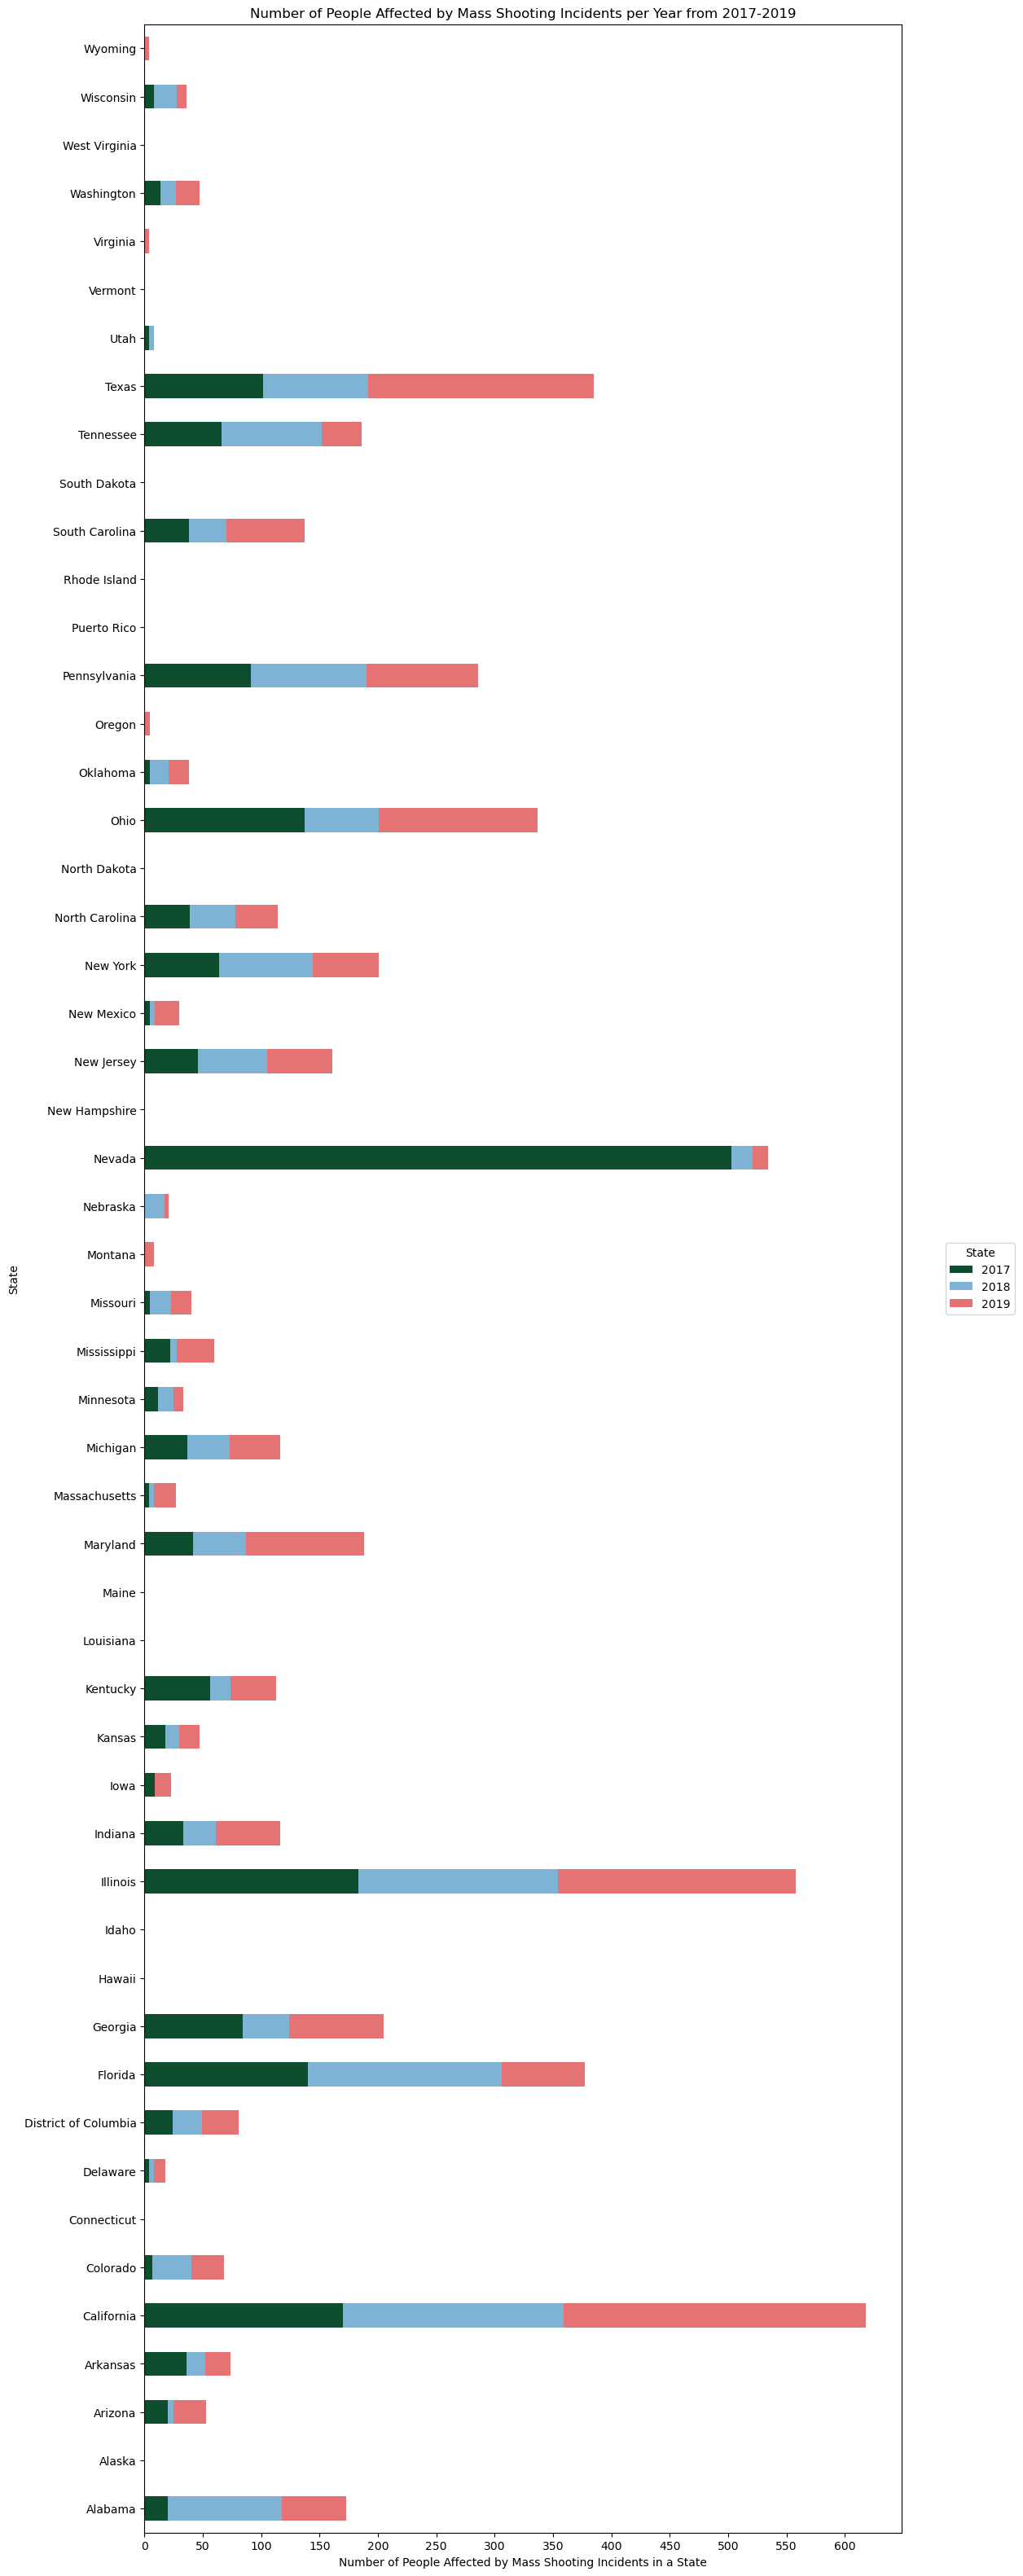

In [570]:
# Create a boxplot showing the number of people affected by mass shooting incidencts per year
hist_GSCD = gun_snap_census_data.copy()
hist_GSCD = hist_GSCD.groupby(["Year", "State"])["Victims"].sum().reset_index(name='sum')
hist_GSCD_pivot = hist_GSCD.pivot(index='State', columns='Year', values='sum')

hist_GSCD_pivot = hist_GSCD_pivot.fillna(0)

custom_colors = ['#0E4D2E', '#7FB3D5', '#E57373']
plt.figure(figsize=(12, 40))
ax = hist_GSCD_pivot.plot(kind='barh', stacked=True, ax=plt.gca(), color=custom_colors)

plt.xticks(range(0,650,50))
plt.xlabel('Number of People Affected by Mass Shooting Incidents in a State')
plt.ylabel('State')
plt.title('Number of People Affected by Mass Shooting Incidents per Year from 2017-2019')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title='State')

plt.show()

In [571]:
# Summary statistics of the number of people affected by mass shooting incidencts per year
hist_GSCD['sum'].fillna(0).describe()

count    156.000000
mean      35.448718
std       61.578724
min        0.000000
25%        0.000000
50%       13.500000
75%       39.250000
max      503.000000
Name: sum, dtype: float64

This graph shows the number of people affected by mass shooting incidents in a state, by state. It is a stack bar plot, with blue representing 2017, orange representing 2018 and green representing 2019. This allows us to see which state overall experiences the most incidients during mass shootings, and which year contributes the most per state.

### Choropleth Of SNAP Participation through out the country.

In [572]:
# For Total 3 Years
snap_data_c = snap_data.copy()
snap_data_c = snap_data_c.groupby(["State"])["Calc: SNAP Total PA and Non-PA People"].sum().reset_index(name='Total PA and Non-PA People')
state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': "AR",
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

snap_data_c['State'] = snap_data_c['State'].map(state_abbreviations)

In [573]:
# Load json data
geo_json_data = json.load(open('data/us-states.json'))

In [574]:
# Series mapping each state to total number of SNAP participants
snap_dict = snap_data_c.set_index('State')['Total PA and Non-PA People']
# Red color scale based on SNAP participant totals
colormap_snap = branca.colormap.linear.Reds_07.scale(snap_data_c['Total PA and Non-PA People'].min(), vmax=snap_data_c['Total PA and Non-PA People'].max())

In [575]:
# Plot chloropleth map
Map_SNAP = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
folium.GeoJson(geo_json_data).add_to(Map_SNAP)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': colormap_snap(snap_dict[feature['id']]),
        'color': 'black',
        'weight': 3,
        'fillOpacity': 0.8,
        'dashArray': '5, 5'
    }
).add_to(Map_SNAP)

colormap_snap.caption = "SNAP Total Participation by State (Number of People)"
colormap_snap.add_to(Map_SNAP)

Map_SNAP

This map shows the number of people who use SNAP benefits in each state. If the color of the state is darker, that means that more people in that state use SNAP benefits. The numbers range from 92,833 people to 11,896,963 people.

In [576]:
# Porportion of Average Population Accessing SNAP in Each State from 2017-2019
snap_data_c1 = snap_data.copy()
snap_data_c1 = snap_data_c1.fillna(0)
snap_data_c1 = snap_data_c1.groupby(["State"])["Calc: SNAP Total PA and Non-PA People"].mean().reset_index(name='Average Total PA and Non-PA People')
us_census_data_c = us_census_data.copy()
us_census_data_c = us_census_data_c.groupby(['State', "Year"])['Total Population'].sum().reset_index(name='Total Population')
us_census_data_c = us_census_data_c.groupby(['State'])['Total Population'].mean().reset_index(name='Average Total Population')

In [577]:
# Combining the Total Population with SNAP Access Participation, with additional column of Proportion
Combined = pd.merge(us_census_data_c, snap_data_c1)
Combined['Proportion'] = Combined['Average Total PA and Non-PA People'] / Combined['Average Total Population']
Combined['State'] = Combined['State'].map(state_abbreviations)

In [578]:
# Series mapping each state to proportion of the state population accessing SNAP
Combined_dict = Combined.set_index('State')['Proportion']
# Red color scale based on SNAP proportions
colormap_combine = branca.colormap.linear.Reds_07.scale(Combined['Proportion'].min(), Combined['Proportion'].max())

In [579]:
# Plot chloropleth map
Map_SNAP_Proportion = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
folium.GeoJson(geo_json_data).add_to(Map_SNAP_Proportion)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': colormap_combine(Combined_dict[feature['id']]),
        'color': 'black',
        'weight': 3,
        'fillOpacity': 0.8,
        'dashArray': '5, 5'
    }
).add_to(Map_SNAP_Proportion)

colormap_combine.caption = "Proportion of State Population Accessing SNAP"
colormap_combine.add_to(Map_SNAP_Proportion)

Map_SNAP_Proportion

This map is very similar to the map above. Instead of showing SNAP participation by number of poeple, it is showing SNAP participation by proportion of the state population accessing SNAP. The proportions range from 0.0 to 0.62. The Midwest has a generally smaller proportion of SNAP users, and the states clustered on the East Coast generally have a higher proportion of SNAP users. By comparing the two graphs, we know that a high total SNAP participation using SNAP does not mean that there is a high proportion of individuals using SNAP relative to the State’s total participation.

# Adapting to the Prediction Task

Our goal is to predict gun violence for a county given the SNAP usage and demographics of that county. There are a couple more data cleaning and adjustment steps to complete in order to fit the data to the prediction task
* Aggregate across counties; we are working with incidents collected at the county level
* Determine how to represent gun violence; we will experiment with a couple options such as True/False (binary), a count of people impacted by incidents (continuous), a "level" gun violence as high, medium, or low (categorical)

In [580]:
# Drop information about incidents
adapted = gun_snap_census_data.copy()
adapted.drop(columns=['Incident ID', 'Incident Date'], inplace=True)

In [581]:
# "Standardize" Victims by turning it into a rate using the total population
adapted["Mass_Shooting_Gun_Violence_rate"] = adapted['Victims'] / adapted['Total Population']

In [582]:
# "Standardize" other counts to by turning them into proportions
race_cols = ['White',
              'Black / African American',
              'American Indian and Alaska Native',
              'Asian',
              'Native Hawaiian and Other Pacific Islander',
             'Hispanic or Latino',
             'Other Race']

proportion_cols = ['Worked Less Than Full Time', 'LABOR: Total Civilian Labor Force',
                   'EDUCATION: Age 25+ Educated Total Population', 'AGE: Under 5', 'AGE: 5 to 17',
                   'AGE: 18-34', 'AGE: 35-64', 'AGE: 65 and older', 'Male', 'Female',
                   'SNAP All Total Actual PA & Non-PA Issuance'] + race_cols

for col in proportion_cols:
  adapted[col + ' Proportion'] = adapted[col] / adapted['Total Population']

# Handle labor totals
labor_cols = ['LABOR: Employed', 'LABOR: Unemployed']
for col in labor_cols:
  adapted[col + ' Proportion'] = adapted[col] / adapted['LABOR: Total Civilian Labor Force']

# Handle education totals
edu_cols = [col for col in adapted.columns if 'EDUCATION: ' in col and col != 'EDUCATION: Age 25+ Educated Total Population']
for col in edu_cols:
  adapted[col + ' Proportion'] = adapted[col] / adapted['EDUCATION: Age 25+ Educated Total Population']

# Handle SNAP totals
people_snap_cols = ['SNAP All Persons Public Assistance Participation', 'SNAP All Persons Non-Public Assistance Participation', 'Calc: SNAP Total PA and Non-PA People']
adapted['SNAP All Persons PA Participation Proportion'] = adapted['SNAP All Persons Public Assistance Participation'] / adapted['Calc: SNAP Total PA and Non-PA People']
adapted['SNAP All Persons Non-PA Participation Proportion'] = adapted['SNAP All Persons Non-Public Assistance Participation'] / adapted['Calc: SNAP Total PA and Non-PA People']

household_snap_cols = ['SNAP All Households Public Assistance Participation', 'SNAP All Households Non-Public Assistance Participation', 'Calc: SNAP Total PA and Non-PA Households']
adapted['SNAP All Households PA Participation Proportion'] = adapted['SNAP All Households Public Assistance Participation'] / adapted['Calc: SNAP Total PA and Non-PA People']
adapted['SNAP All Households Non-PA Participation Proportion'] = adapted['SNAP All Households Non-Public Assistance Participation'] / adapted['Calc: SNAP Total PA and Non-PA Households']

# Drop extraneous columns
adapted.drop(columns=proportion_cols, inplace=True)
adapted.drop(columns=labor_cols, inplace=True)
adapted.drop(columns=edu_cols, inplace=True)
adapted.drop(columns=people_snap_cols, inplace=True)
adapted.drop(columns=household_snap_cols, inplace=True)

# Handle dividing by 0
adapted = adapted.fillna(0)

# Feature Selection

In [583]:
# Drop all the columns that are no longer needed and also measure gun violence (prevent leakage)
# Need all the variables to be floats/integers for correlation matrix
X_analyze = adapted.copy()
columns_to_drop = ['Year',
                   'Total Population',
                   'Victims',
                   'Victims Killed',
                   'Victims Injured',
                   'Suspects Injured',
                   'Suspects Arrested',
                   'Suspects Killed',
                   'Below Poverty Level', # percent below poverty line is more important
                   'County',
                   'State']

# Explanatory Variables
X_analyze = X_analyze.drop(columns = columns_to_drop)

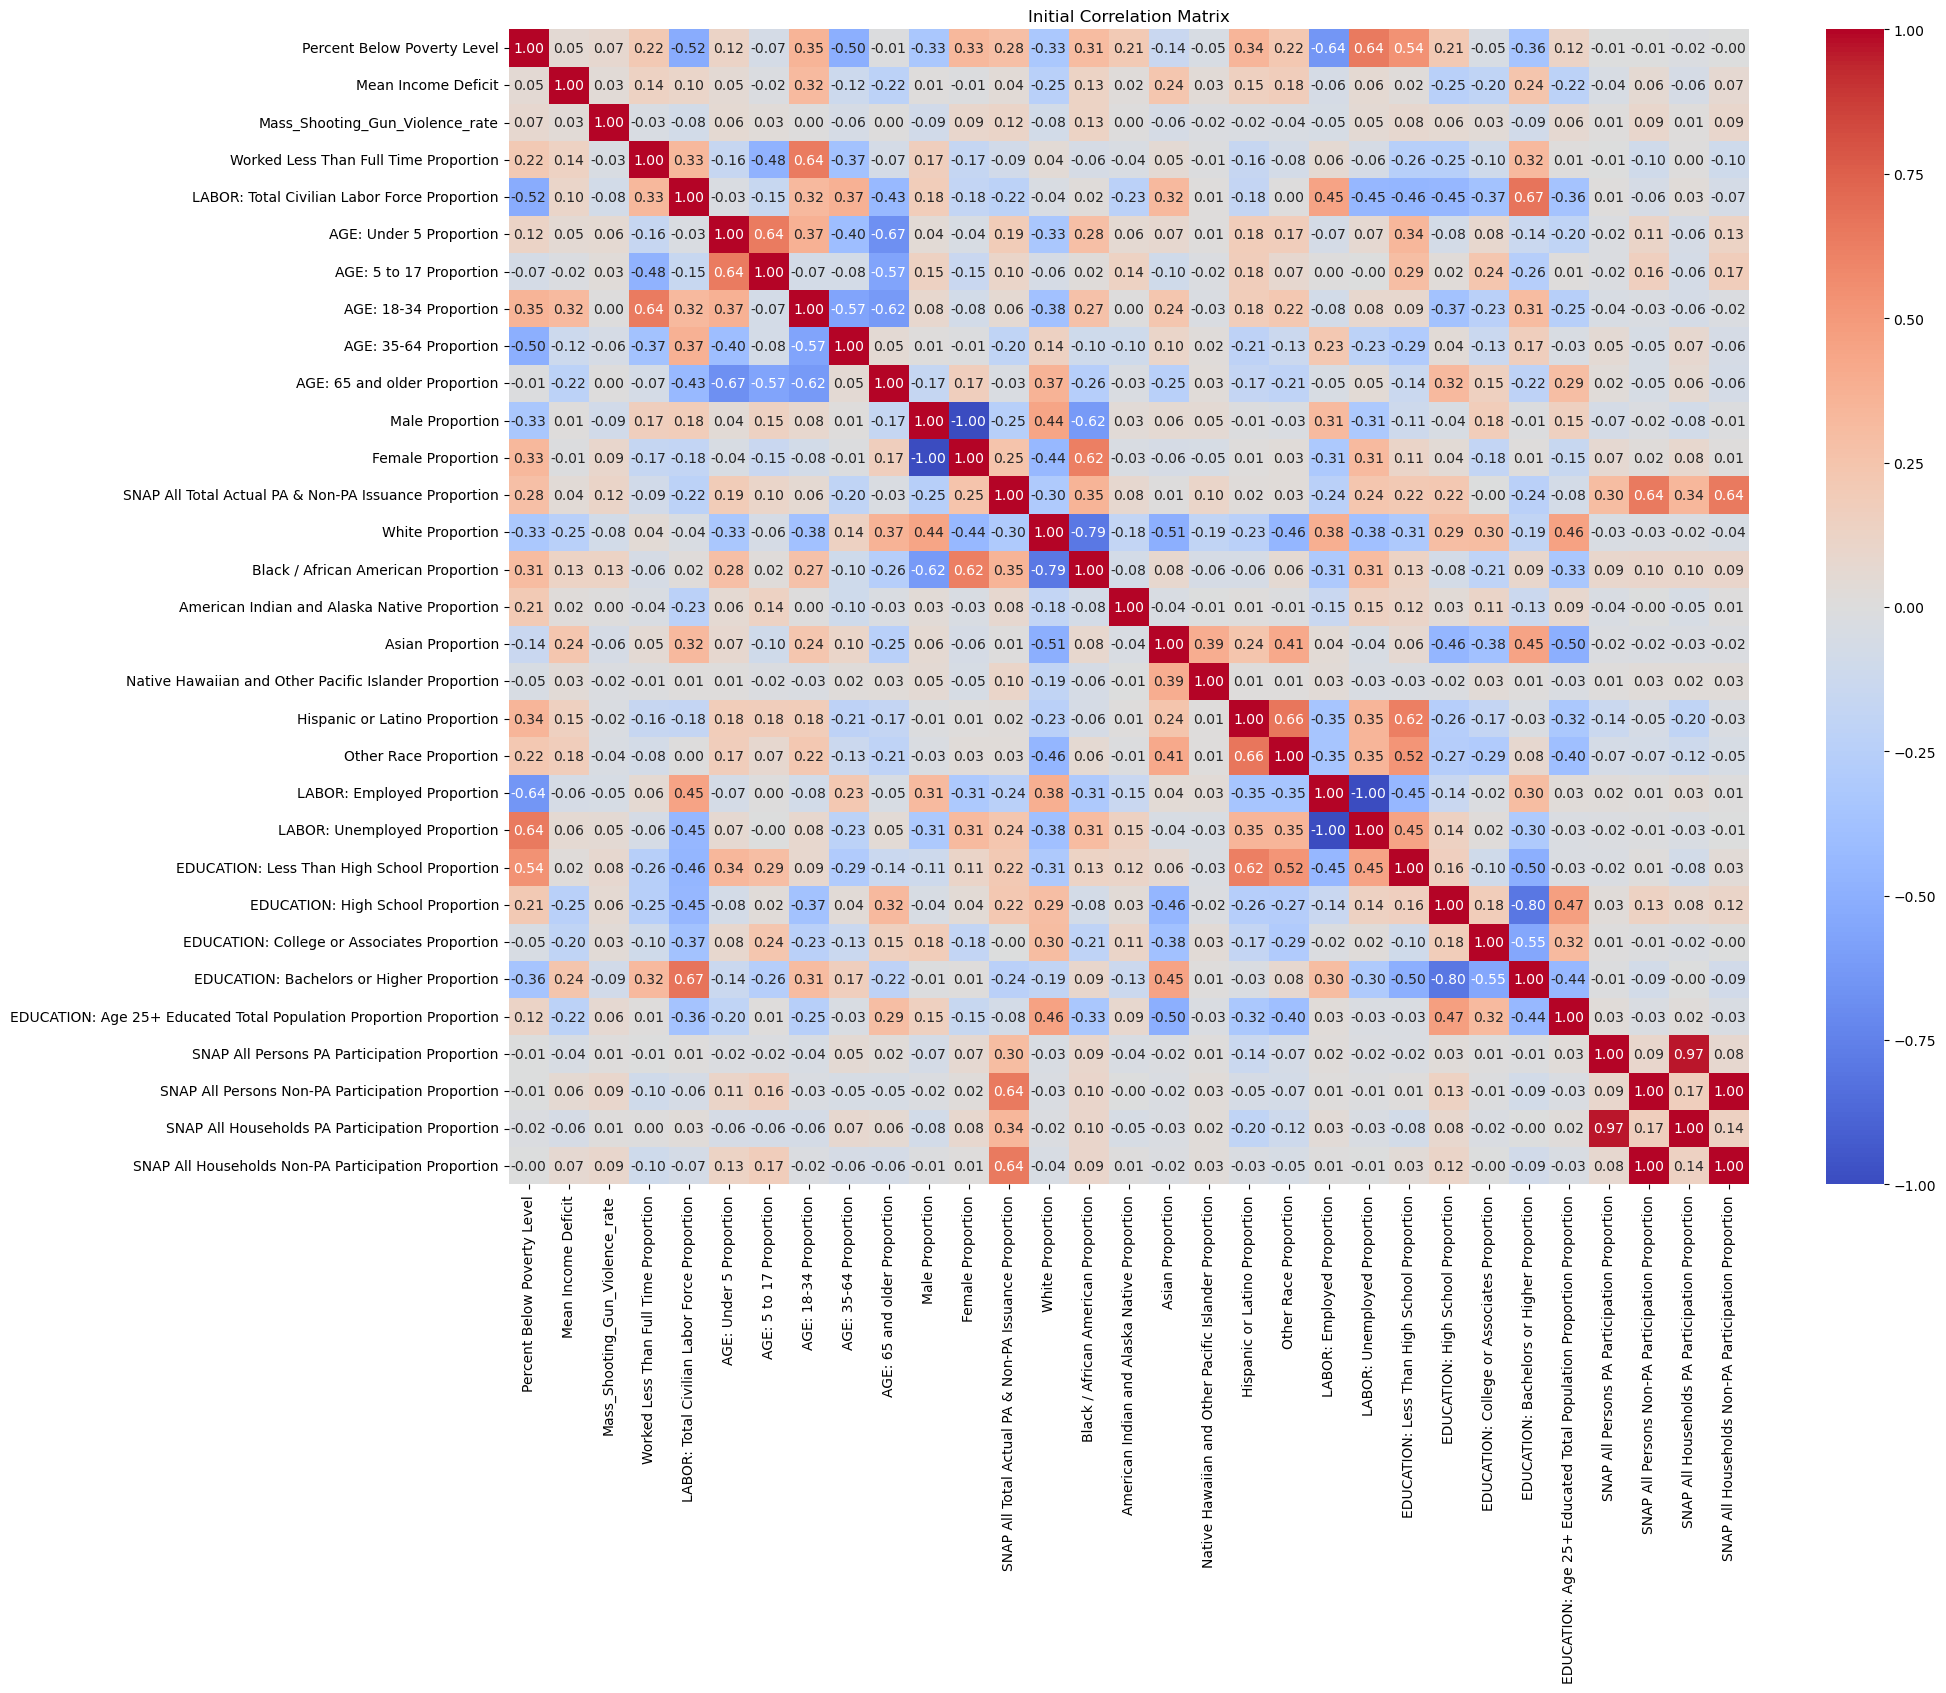

In [584]:
# Corrrelation matrix
corr_matrix = X_analyze.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Initial Correlation Matrix')
plt.show()

In [585]:
def drop_non_numeric_columns(df):
    """
    Remove any non numeric columns
    """
    column_types = df.dtypes
    non_numeric_columns = []
    for column_name, data_type in column_types.items():
        if not pd.api.types.is_numeric_dtype(data_type):
            non_numeric_columns.append(column_name)
    df_numeric = df.drop(columns=non_numeric_columns)
    return df_numeric

In [586]:
# Remove non numeric columns for correlation matrix
corr_matrix_data = drop_non_numeric_columns(X_analyze)
corr_matrix = corr_matrix_data.corr()

# Compute the highest correlated features with Mass_Shooting_Victims_rate
cleaned_corr = corr_matrix[corr_matrix < 1.00]
corr_reset = cleaned_corr.reset_index(names=['Feature'])

# Get correlations with Mass_Shooting_Victims_rate
vic_filtered = corr_reset[corr_reset['Feature'] == 'Mass_Shooting_Gun_Violence_rate']
vic_corr_df = vic_filtered.transpose().rename(columns={2: 'Correlation'}).iloc[1:,]

# Remove NaN from correlation with self
vic_corr_df = vic_corr_df[vic_corr_df['Correlation'].notna()]

In [587]:
# Sort for 15 most positive correlations
most_pos_correlated = vic_corr_df.sort_values(by='Correlation', ascending=False).iloc[:15,]
most_pos_correlated

,Correlation
Black / African American Proportion,0.132461
SNAP All Total Actual PA & Non-PA Issuance Proportion,0.115468
SNAP All Households Non-PA Participation Proportion,0.092261
SNAP All Persons Non-PA Participation Proportion,0.092166
Female Proportion,0.090379
EDUCATION: Less Than High School Proportion,0.0777
Percent Below Poverty Level,0.07498
EDUCATION: Age 25+ Educated Total Population Proportion Proportion,0.062946
AGE: Under 5 Proportion,0.061095
EDUCATION: High School Proportion,0.05746


In [588]:
# Sort for 15 most negative correlations
most_neg_correlated = vic_corr_df.sort_values(by='Correlation', ascending=True).iloc[:15,]
most_neg_correlated

,Correlation
Male Proportion,-0.090379
EDUCATION: Bachelors or Higher Proportion,-0.088146
LABOR: Total Civilian Labor Force Proportion,-0.083744
White Proportion,-0.080975
AGE: 35-64 Proportion,-0.055751
Asian Proportion,-0.055562
LABOR: Employed Proportion,-0.051149
Other Race Proportion,-0.035723
Worked Less Than Full Time Proportion,-0.03477
Hispanic or Latino Proportion,-0.024905


_Some feature selection has already occurred when importing the original dataset -- the initial features of interest were selected._

The most positively correlated features with mass shooting gun violence rate are most related to SNAP usage, education, poverty level, labor, income, and age. The most negatively correlated features with mass shooting victim rate are most related to race, gender, and labor.

Gender and race are the more highly correlated features. Including them in the model risks producing mass shooting predictions that represent certain groups of people negatively, which raises ethical concerns. However, including them in the model could also help to detect bias and raise accountability if the model's performance across counties with different demographic groups is effectively and thoroughly evaluated.

Many of these features are highly correlated with each other, or can be captured by another. We will select the most relevant features and drop redundant or irrelevant features. This will also help to prevent overfitting.

Male proportion and female proportion are completely dependent on each other, so we will drop one (male proportion). SNAP All Households PA Participation Proportion and SNAP All Persons PA Participation Proportion are closely correlated, so we will drop one (SNAP All Households PA Participation Proportion). SNAP All Households Non-PA Participation Proportion and SNAP All Persons Non-PA Participation Proportion are closely correlated, so we will drop one (SNAP All Households Non-PA Participation Proportion).

Additionally, for the Age and Education data, we picked specific groups within the data, rather than using all the groups. This helped us focus our data and minimize the number of redundant or extraneous features.
* Age: The original groups for the Age category were AGE: Under 5 Proportion, AGE: 5 to 17 Proportion, AGE: 18-34 Proportion, AGE: 35-64 Proportion, and AGE: 65 and older Proportion. We chose to focus on the groups AGE: Under 5 Proportion and AGE: 5 to 17 Proportion because families with children are more likely to rely on SNAP and because schools are susceptible to mass shootings in the United States.
* Education: The original groups for the Education category were EDUCATION: Less Than High School Proportion, EDUCATION: High School Proportion, EDUCATION: College or Associates Proportion, and EDUCATION: Bachelors or Higher Proportion. We chose to focus on the groups EDUCATION: Less Than High School Proportion and EDUCATION: College or Associates Proportion, given that these groups most thoroughly covered the other groups and were most likely to be groups relying on SNAP.
* Race: We did not get rid of certain groups, so as to not introduce bias or associate specific races with the context of mass shootings.

In [589]:
# Refine the set of explanatory variables
cols_to_drop = ['Male Proportion',
                'SNAP All Households PA Participation Proportion',
                'SNAP All Households Non-PA Participation Proportion',
                'LABOR: Unemployed Proportion',
                'Mass_Shooting_Gun_Violence_rate',
                'Worked Less Than Full Time Proportion',
                'AGE: 18-34 Proportion',
                'AGE: 35-64 Proportion',
                'AGE: 65 and older Proportion',
                'EDUCATION: High School Proportion',
                'EDUCATION: Bachelors or Higher Proportion',]
X = X_analyze.drop(cols_to_drop, axis=1)

# Response variable
y = X_analyze["Mass_Shooting_Gun_Violence_rate"]

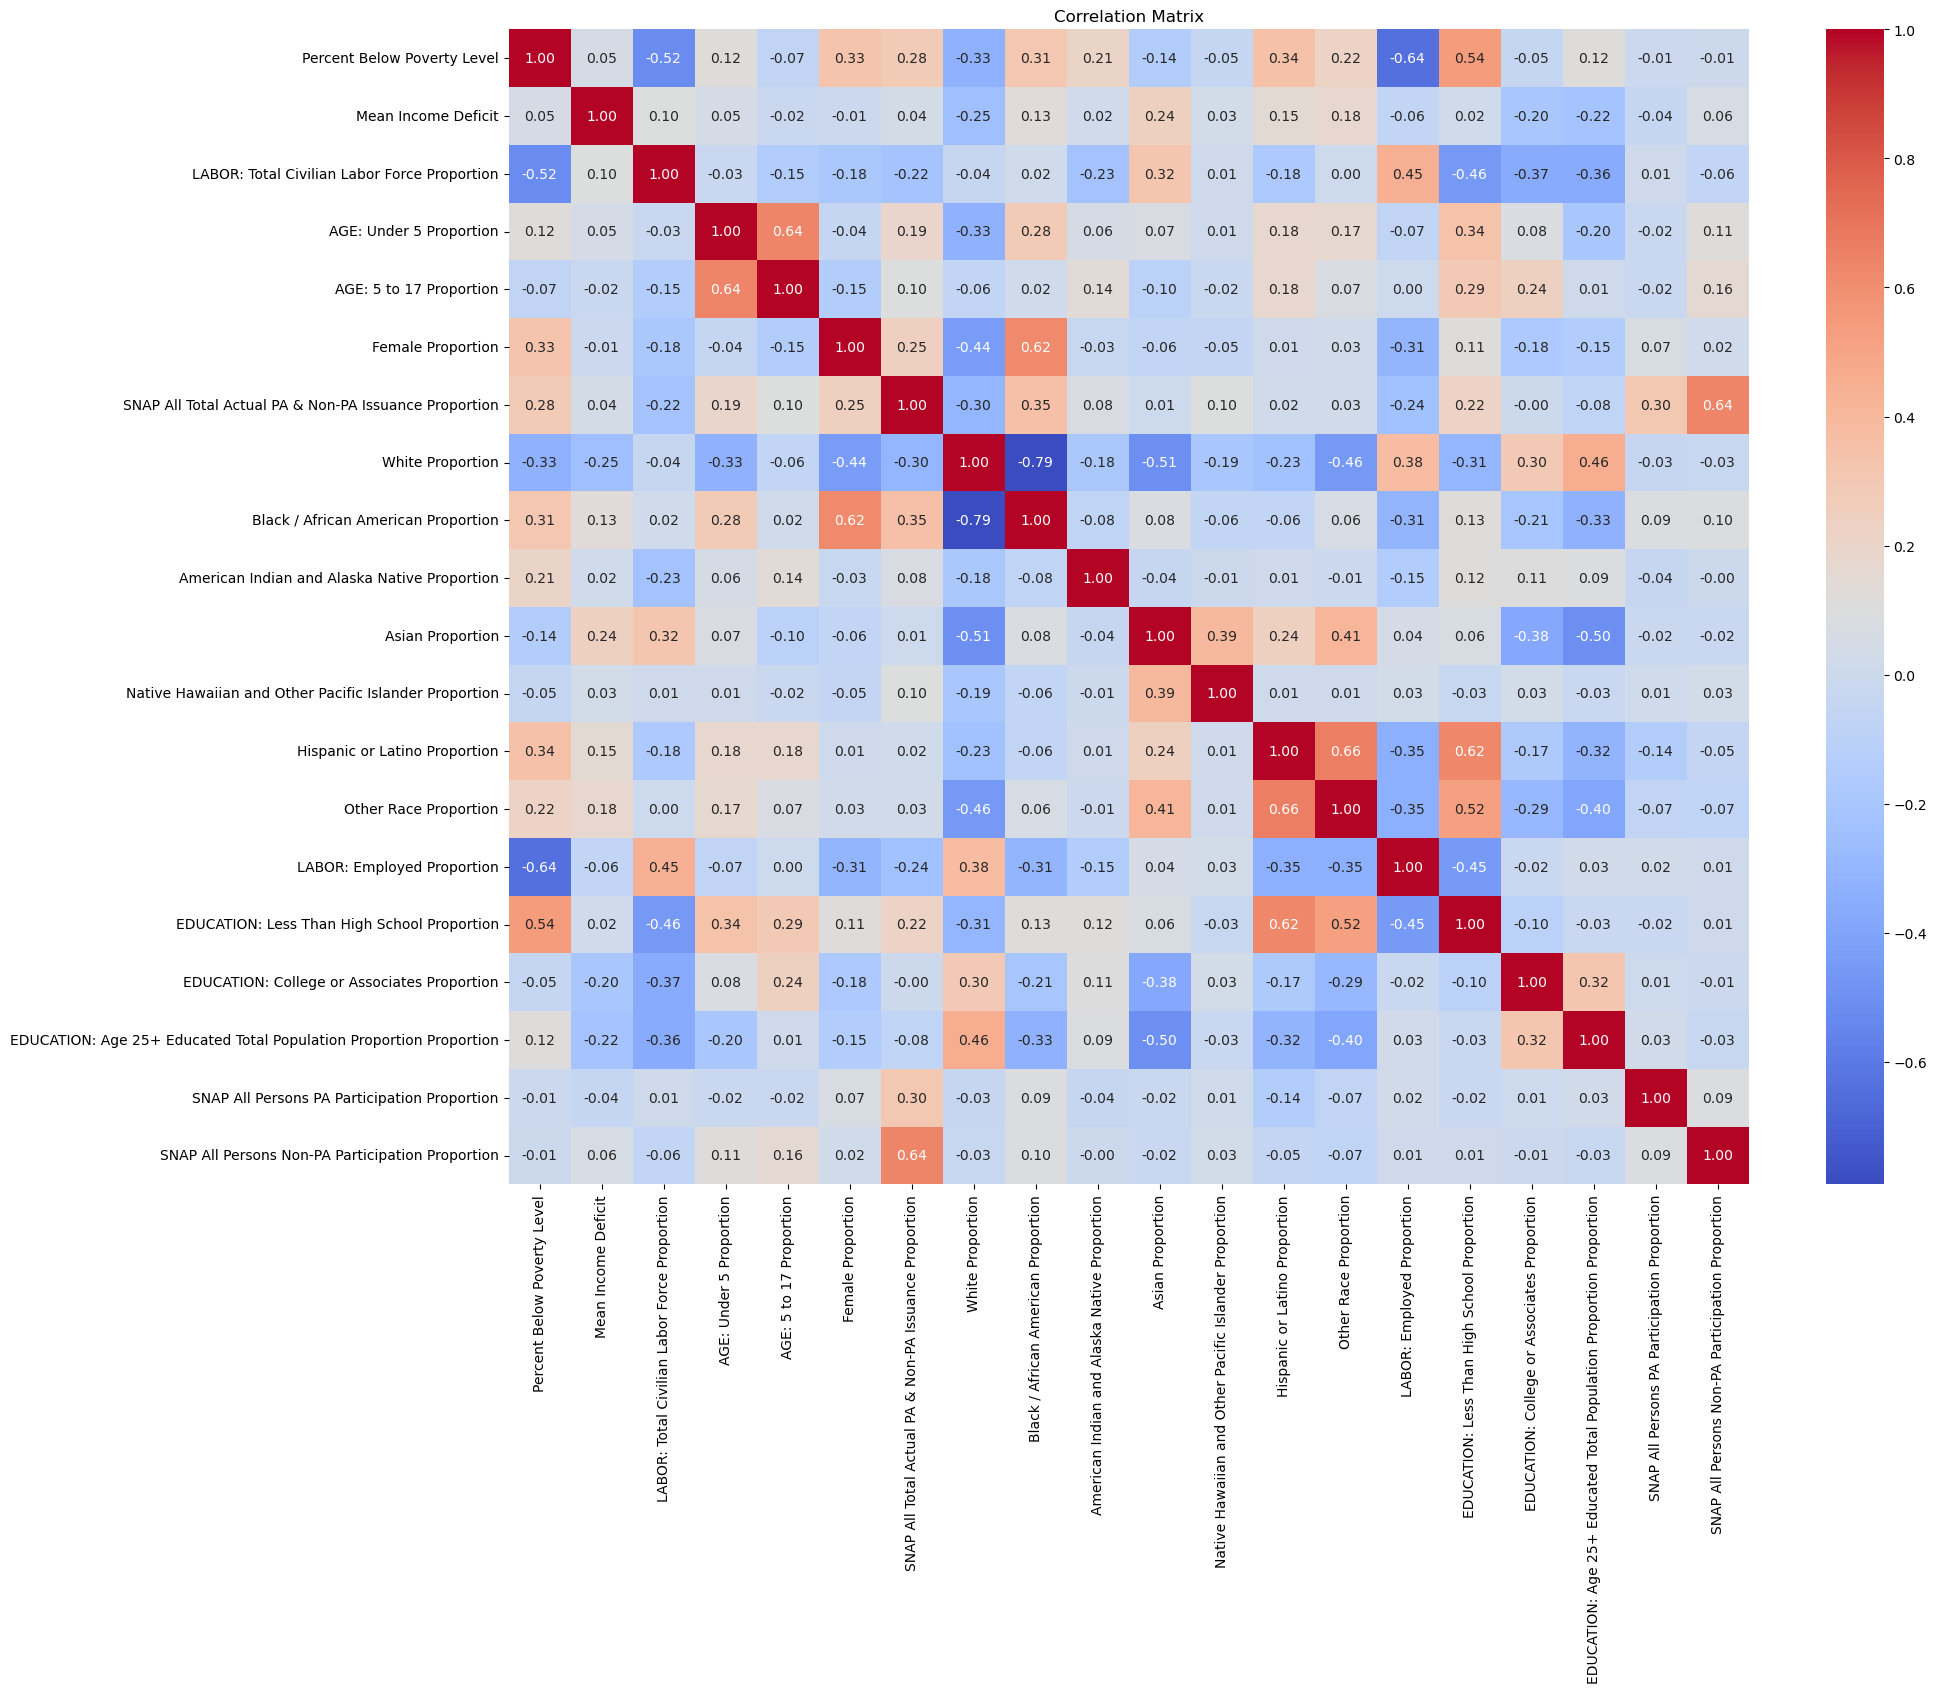

In [590]:
# Plot correlation matrix
corr_matrix = X.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Data Splitting & Scaling

In [591]:
# Split the data to separate training and test sets
np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

# Train scaler on X_train
scaler = StandardScaler()
scaler.fit(X_train)

# Scale train and test set on scale from X_train
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

We are scaling the X values because many of the features have completely different scales. For example, any of the values that are based on proportions range from (0, 1) whereas mean income deficit ranges from (0, 10,821). Scaling can help the performance and speed of some of the algorithms.

In [592]:
# Scaling y values
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.fit_transform(y_test.values.reshape(-1, 1))

We are scaling the Y values because the current scale is extremely small -- scaling the Y values to be larger makes them more distinguishable and easier to interpret.

# Model Selection: Regression Models

### Ordinary Least Squares
The ordinary least squares (OLS) model is a linear regression model that minimizes the sum of squared differences between observed and predicted values, and serves as an excellent baseline model.


### Decision Tree Regression
Decision Tree Regression is suitable for datasets with nonlinear relationships, is robust against outliers, and it is easy to understand and visualize.


### AdaBoost Regression
The AdaBoost model enhances accuracy by converting weak classifiers into a strong one. It is effective for handling large datasets with many features, it manages non-linear relationships well, and it is less prone to overfitting.

## Ordinary Least Squares

In [593]:
# Turn arrays into series because easier to work with
y_train = pd.Series(y_train.flatten())
y_test = pd.Series(y_test.flatten())

In [594]:
# Add constant for intercept and reset indices
X_train_constant = sm.add_constant(X_train)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Initialize and fit the model
ols = sm.OLS(y_train, X_train_constant)
ols = ols_model.fit()

In [595]:
# Calculate RMSE and r-squared for training data
y_train_pred = ols.predict(X_train_constant)
train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
train_r2 = ols.rsquared

# Calculate RMSE and r-squared for test data
X_test_constant = sm.add_constant(X_test)
y_test_pred = ols.predict(X_test_constant)
test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
test_r2 = r2_score(y_test, y_test_pred)

print("Root Mean Squared Error (RMSE) on training data:", train_rmse)
print("Root Mean Squared Error (RMSE) on test data:", test_rmse)
print("R-squared (R^2) on training data:", train_r2)
print("R-squared (R^2) on test data:", test_r2)

Root Mean Squared Error (RMSE) on training data: 0.9745280648328938
Root Mean Squared Error (RMSE) on test data: 0.9838797434762041
R-squared (R^2) on training data: 0.0502950508530553
R-squared (R^2) on test data: 0.031980650377199216


In [596]:
# Summary of results
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     6.450
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           2.03e-17
Time:                        22:50:43   Log-Likelihood:                -3422.9
No. Observations:                2457   AIC:                             6888.
Df Residuals:                    2436   BIC:                             7010.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
const                                                              -3.331e-16      0.020  -1.69e-14      1.000      -0.039       0.039
Percent Below Poverty Level                                           -0.0755      0.033     -2.253      0.024      -0.141      -0.010
Mean Income Deficit                                                    0.0608      0.022      2.810      0.005       0.018       0.103
LABOR: Total Civilian Labor Force Proportion                          -0.0067      0.031     -0.215      0.829      -0.067       0.054
AGE: Under 5 Proportion                                                0.0524      0.030      1.731      0.084      -0.007       0.112
AGE: 5 to 17 Proportion                                               -0.0825      0.030     -2.760      0.006      -0.141      -0.024
Female Proportion                                                      0.0440      0.028      1.549      0.122      -0.012       0.100
SNAP All Total Actual PA & Non-PA Issuance Proportion                  0.0350      0.032      1.086      0.278      -0.028       0.098
White Proportion                                                       0.0304      0.116      0.263      0.793      -0.196       0.257
Black / African American Proportion                                    0.1578      0.098      1.604      0.109      -0.035       0.351
American Indian and Alaska Native Proportion                           0.0221      0.036      0.612      0.540      -0.049       0.093
Asian Proportion                                                       0.0082      0.047      0.175      0.861      -0.084       0.100
Native Hawaiian and Other Pacific Islander Proportion                 -0.0115      0.026     -0.441      0.659      -0.063       0.040
Hispanic or Latino Proportion                                          0.0150      0.034      0.435      0.663      -0.052       0.082
Other Race Proportion                                                 -0.0343      0.045     -0.757      0.449      -0.123       0.055
LABOR: Employed Proportion                                             0.0213      0.029      0.742      0.458      -0.035       0.078
EDUCATION: Less Than High School Proportion                            0.1204      0.035      3.448      0.001       0.052       0.189
EDUCATION: College or Associates Proportion                            0.0683      0.026      2.622      0.009       0.017       0.119
EDUCATION: Age 25+ Educated Total Population Proportion Proportion     0.1080      0.031      3.514      0.000       0.048       0.168
SNAP All Persons PA Participation Proportion                          -0.0140      0.021     -0.655      0.513   

In [597]:
# Investigate feature coefficients
coefficients = ols_results.params[1:]
variable_names = X_train.columns
coefficients_df = pd.DataFrame({'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
coefficients_df

,Coefficient
Black / African American Proportion,0.157775
EDUCATION: Less Than High School Proportion,0.120442
EDUCATION: Age 25+ Educated Total Population Proportion Proportion,0.108033
EDUCATION: College or Associates Proportion,0.068308
SNAP All Persons Non-PA Participation Proportion,0.065331
Mean Income Deficit,0.060754
AGE: Under 5 Proportion,0.052398
Female Proportion,0.043976
SNAP All Total Actual PA & Non-PA Issuance Proportion,0.035038
White Proportion,0.030367


### OLS Conclusion
The OLS results are not very good. The RMSE values are very high (greater than 0.97) for the training and test data. The R squared values are very low (less than 0.05). This all indicates that the model is not capturing the underlying patterns of the data very well. The dataframe above shows each independent variable, and sorts by their coefficients. This shows that the indpenedent variable that had the biggest influence on predicting gun violence was 'Black/African American Proportion'.

# Decision Tree Regression

In [615]:
# Initialize and fit baseline model
dtr_baseline = DecisionTreeRegressor(random_state = 42)
dtr_baseline = dtc_baseline.fit(X_train, y_train)

In [616]:
# Calculate RMSE and r-squared for training data
y_train_pred = dtr_baseline.predict(X_train)
train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
train_r2 = dtr_baseline.score(X_train, y_train)

# Calculate RMSE and r-squared for test data
y_test_pred = dtr_baseline.predict(X_test)
test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
test_r2 = dtr_baseline.score(X_test, y_test)

print("Root Mean Squared Error (RMSE) on training data:", train_rmse)
print("Root Mean Squared Error (RMSE) on test data:", test_rmse)
print("R-squared (R^2) on training data:", train_r2)
print("R-squared (R^2) on test data:", test_r2)

Root Mean Squared Error (RMSE) on training data: 0.16283312917718362
Root Mean Squared Error (RMSE) on test data: 1.182488993383946
R-squared (R^2) on training data: 0.9734853720423666
R-squared (R^2) on test data: -0.39828021947417724


In [604]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [2, 4, 6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [.01, .001]
}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state = 42), 
                           param_grid = param_grid, 
                           cv = 5, 
                           scoring = 'r2')
grid_search.fit(X_train, y_train)
grid_search.cv_results_["params"][best_index]

{'ccp_alpha': 0.01,
 'max_depth': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

In [617]:
# Initialize and fit a new model with the best hyperparameters
dtr = DecisionTreeRegressor(max_depth = 2, 
                                        min_samples_leaf = 4, 
                                        min_samples_split = 10, 
                                        ccp_alpha = 0.01,
                                        random_state = 42)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.01, max_depth=2, min_samples_leaf=4,
                      min_samples_split=10, random_state=42)

In [618]:
# Calculate RMSE and r-squared for training data
y_train_pred = dtr.predict(X_train)
train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
train_r2 = dtr.score(X_train, y_train)

# Calculate RMSE and r-squared for training data
y_test_pred = dtr.predict(X_test)
test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
test_r2 = dtr.score(X_test, y_test)

print("Root Mean Squared Error (RMSE) on training data:", train_rmse)
print("Root Mean Squared Error (RMSE) on test data:", test_rmse)
print("R-squared (R^2) on training data:", train_r2)
print("R-squared (R^2) on test data:", test_r2)

Root Mean Squared Error (RMSE) on training data: 0.9575432886267159
Root Mean Squared Error (RMSE) on test data: 0.9884991978458121
R-squared (R^2) on training data: 0.08311085040593391
R-squared (R^2) on test data: 0.02286933585818629


### Decision Tree Regressor Conclusion
The Decision Tree Regressor results were also not very good. The R-squared values are extremeley low - this could likely be because of noise in the data, since counties are very heterogenous and mass shootings are rare. Predicting mass shooting gun violence rates could be especially difficult since the numbers are also really small.

# AdaBoost Regressor

In [619]:
# Initialize and fit model
# Use the DecisionTreeRegressor as the base estimator
abr_baseline = AdaBoostRegressor(estimator = dtc_baseline, 
                                 random_state = 42)
abr_baseline = ada_regressor.fit(X_train, y_train)

In [620]:
# Calculate RMSE and r-squared for training data
y_train_pred = abr_baseline.predict(X_train)
train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
train_r2 = abr_baseline.score(X_train, y_train)

# Calculate RMSE and r-squared for test data
y_test_pred = abr_baseline.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
score = abr_baseline.score(X_test, y_test)

print("Root Mean Squared Error (RMSE) on training data:", train_rmse)
print("Root Mean Squared Error (RMSE) on test data:", test_rmse)
print("R-squared (R^2) on training data:", train_r2)
print("R-squared (R^2) on test data:", test_r2)

Root Mean Squared Error (RMSE) on training data: 0.2576494057751774
Root Mean Squared Error (RMSE) on test data: 1.1433170676499533
R-squared (R^2) on training data: 0.9336167837036979
R-squared (R^2) on test data: 0.02286933585818629


In [609]:
# Hyperparameter tuning
param_grid = {
    'estimator__max_depth': [1, 2, 3],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}
grid_search = GridSearchCV(abr, 
                           param_grid = param_grid,
                           cv = 5, 
                           scoring = 'r2')
grid_search.fit(X_train, y_train)
grid_search.cv_results_["params"][best_index]

{'estimator__max_depth': 1, 'learning_rate': 0.5, 'n_estimators': 200}

In [621]:
# Initalize and fit a new model with the best hyperparameters
abr = AdaBoostRegressor(learning_rate = 0.5,
                        n_estimators = 200,
                        estimator = dtc_baseline, 
                        random_state = 42)
abr = abr.fit(X_train, y_train)

In [623]:
# Score the model on the training and validation data
y_train_pred = abr.predict(X_train)
train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
train_r2 = abr.score(X_train, y_train)

# Calculate RMSE and r-squared for test data
y_test_pred = abr.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = abr.score(X_test, y_test)

print("Root Mean Squared Error (RMSE) on training data:", train_rmse)
print("Root Mean Squared Error (RMSE) on test data:", test_rmse)
print("R-squared (R^2) on training data:", train_r2)
print("R-squared (R^2) on test data:", test_r2)

Root Mean Squared Error (RMSE) on training data: 0.2863689608211424
Root Mean Squared Error (RMSE) on test data: 1.1643993477625003
R-squared (R^2) on training data: 0.917992818278219
R-squared (R^2) on test data: -0.35582584106973547


### AdaBoost Regressor Conclusion
The AdaBoost Regressor results are also quite terrible. We decided to look into other ways to represent the outcome besides as a continuous rate.

# Model Selection: Binary Classification

None of our previous regression models, which predict "Mass Shooting Gun Violence Rate" as a continuous variable, have performed well. Therefore, we are going to switch over to **_Binary Classification_**. We will label a county as "Low Mass Shooting Gun Violence Rate" if it's rate is less than 0.00002 (the third quartile of "Mass Shooting Gun Violence Rate"). We will label a county as "High Mass Shooting Gun Violence Rate" if it's rate is above or equal to 0.0002. These two labels will serve as binary indicators that we will predict using the classifiers. We are using Logistic Regression, Decision Tree Classifier, and AdaBoost Classifier. Each model has it's own strength and weaknesses, which are defined below.

### Logistic Regression
Logistic Regression creates a linear combination of the predictor variables and transforms it using the logistic function, applying a threshold to the predicted probabilities for binary predictions. Our threshold was the third quartile for mass shooting gun violence rate (0.000002). The model is interpretable with its coefficients showing the change in log odds of the mass shooting gun violence rate for a unit change in a predictor. One downside is that the relationship between our independent variables (SNAP, demographics, education, etc.) is not very well represented by a linear relationship, as we saw from our OLS model. However, this model will be able to deal with our large number of features well and pick the features that are most important.

### Decision Tree Classifier
Decision Tree Classifier can deal with non-linear relationships. SNAP usage, poverty level, education, mass shooting victims rate, etc. are likely to be non-linear and multifaceted. It can also help identify the most important features, which is one of our goals for the project and is less affected by outliers and interpretable.

### AdaBoost Classifier
The AdaBoost Classifier focuses on converting a set of weak classifiers into a strong one, thus achieving higher accuracy compared to models with individual classifiers. Given the results of the DecisionTree model, it may also help to improve the accuracy through how it updates the weights; this improvement will help to reevaluate the most predictive features. In this case, as we have a large number of features spanning categories of age, labor, SNAP usage, race, and education, it helps to select the most important ones -- the weights that AdaBoost assigns will be useful for this. It is good at handling datasets with non-linear relationships, which gives more flexibility given that several of our features, such as SNAP usage and certain races, may not have linear relationships. It is also less likely to have the problem of overfitting.

# Logistic Regression

In [624]:
# Set the threshold at the 3rd quartile
# Create an indicator where 1 = High Mass Shooting Victim Rate, and 0 = Low Mass Shooting Victim Rate
def map_to_binary(value):
    if value < 0.000002:
        return 0
    else:
        return 1
y = y.apply(map_to_binary)

In [625]:
# Split the data to separate training and test sets
np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

# Scaling X values
scaler = StandardScaler()
scaler.fit(X_train)

# Scale train and test set on scale from X_train
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [626]:
# Add constant for intercept and reset indices
X_train_constant = sm.add_constant(X_train)
X_train_constant.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Initialize and fit model
logit_model = sm.Logit(y_train, X_train_constant)
logit_results = logit_model.fit()
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.445137
         Iterations 7
                                  Logit Regression Results                                 
Dep. Variable:     Mass_Shooting_Gun_Violence_rate   No. Observations:                 2457
Model:                                       Logit   Df Residuals:                     2436
Method:                                        MLE   Df Model:                           20
Date:                             Mon, 14 Apr 2025   Pseudo R-squ.:                  0.2228
Time:                                     22:58:35   Log-Likelihood:                -1093.7
converged:                                    True   LL-Null:                       -1407.1
Covariance Type:                         nonrobust   LLR p-value:                6.199e-120
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

In [627]:
# Calculate training set accuracy
print('Training Set Accuracy: ', logit.score(X_train, y_train))

Training Set Accuracy:  0.792022792022792


In [628]:
# Make predictions on test set
y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)[:, 1]

In [629]:
# Calculate metrics to use for comparison at the end of the notebook
logit_accuracy = accuracy_score(y_test, y_pred)
logit_auc_roc = roc_auc_score(y_test, y_prob)
logit_recall = recall_score(y_test, y_pred)
logit_precision = precision_score(y_test, y_pred)

In [630]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Not High Rate', 'Actually High Rate'],
                            columns = ['Predicted Not High Rate', 'Predicted High Rate'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
                        Predicted Not High Rate  Predicted High Rate
Actually Not High Rate                      415                   40
Actually High Rate                           88                   72

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       455
           1       0.64      0.45      0.53       160

    accuracy                           0.79       615
   macro avg       0.73      0.68      0.70       615
weighted avg       0.78      0.79      0.78       615

Accuracy: 0.791869918699187
ROC AUC: 0.7890934065934067


The accuracy is 0.792, indicating that our model did a decent job of classifying counties as low or high mass shooting gun violence rate. Our AUC-ROC score is decent at 0.78, indicating decent performance. The recall score indicates that our model correctly identifies about 45% of the high mass shooting gun violence rates counties. The precision score indicates that about 64% of the counties classified as high mass shooting gun violence rate counties are truly high. All of these metrics together indicate a mediocre performance of the model. This is likely because the relationship between all of the independent variables (SNAP, demographics, education, etc.) are not well represented linearly.

## Decision Tree Classifier

In [631]:
# Initialize and fit the baseline model
dtc_baseline = DecisionTreeClassifier(random_state = 42)
dtc_baseline = dtc_baseline.fit(X_train, y_train)

In [632]:
# Calculate training and test set accuracy
print('Training Set Accuracy: ', dtc_baseline.score(X_train, y_train))
print('Test Set Accuracy: ', dtc_baseline.score(X_test, y_test))

Training Set Accuracy:  0.9943019943019943
Test Set Accuracy:  0.8552845528455284


In [633]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [.01, .001],
}
grid_search = GridSearchCV(dtc_baseline, 
                           param_grid = param_grid, 
                           cv = 5, 
                           scoring = 'roc_auc')
grid_search.fit(X_train, y_train)
grid_search.cv_results_["params"][best_index]

{'ccp_alpha': 0.01,
 'max_depth': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

In [634]:
# Initalize and fit a new model with the best hyperparameters
dtc = DecisionTreeClassifier(ccp_alpha = 0.01, 
                             max_depth = 3, 
                             min_samples_leaf = 4, 
                             min_samples_split = 10, 
                             random_state = 42)
dtc.fit(X_train, y_train)

# Calculate training set accuracy
print('Training Set Accuracy: ', dtc.score(X_train, y_train))

Training Set Accuracy:  0.8274318274318274


In [635]:
# Make predictions on test set
y_pred = dtc.predict(X_test)
y_prob = dtc.predict_proba(X_test)[:, 1]

In [636]:
# Calculate metrics to use for comparison at the end of the notebook
dtc_accuracy = accuracy_score(y_test, y_pred)
dtc_auc_roc = roc_auc_score(y_test, y_prob)
dtc_recall = recall_score(y_test, y_pred)
dtc_precision = precision_score(y_test, y_pred)

In [637]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Not High Rate', 'Actually High Rate'],
                            columns = ['Predicted Not High Rate', 'Predicted High Rate'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
                        Predicted Not High Rate  Predicted High Rate
Actually Not High Rate                      444                   11
Actually High Rate                           86                   74

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       455
           1       0.87      0.46      0.60       160

    accuracy                           0.84       615
   macro avg       0.85      0.72      0.75       615
weighted avg       0.85      0.84      0.82       615

Accuracy: 0.8422764227642277
ROC AUC: 0.8132967032967033


In [640]:
# Top 10 feature importances dataframe
importances = dtc.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(10))

                                              Feature  Importance
17  EDUCATION: Age 25+ Educated Total Population P...    0.824914
8                 Black / African American Proportion    0.175086
0                         Percent Below Poverty Level    0.000000
11  Native Hawaiian and Other Pacific Islander Pro...    0.000000
18       SNAP All Persons PA Participation Proportion    0.000000
16        EDUCATION: College or Associates Proportion    0.000000
15        EDUCATION: Less Than High School Proportion    0.000000
14                         LABOR: Employed Proportion    0.000000
13                              Other Race Proportion    0.000000
12                      Hispanic or Latino Proportion    0.000000


The accuracy is approximately 0.84, indicating that 84.22% of the total predictions on counties with high mass shootings are right. The AUC-ROC score is approximately 0.81, indicating that the model has good ability to distinguish between positive and negative class outcomes. The recall is 0.46, meaning that the classifier correctly identifies about 46% of the true counties with high mass shootings. The precision is 0.87, meaning that 87% of high mass shootings counties predicted are correct. The decision tree model relies almost entirely on a two features ("EDUCATION: Age 25+ Educated Total Population" and "Black / African American Proportion"). This heavy reliance suggests the model may be overfitting or failing to capture broader patterns.

## AdaBoost Classifier

In [641]:
# Initilize and fit baseline model
# Use the tuned Decision Tree classifier as the base estimator
abc_baseline = AdaBoostClassifier(estimator = dtc, 
                                  random_state = 42)
abc_baseline = abc_baseline.fit(X_train, y_train)

In [642]:
# Calculate training and test set accuracy
print('Training Set Accuracy: ', abc_baseline.score(X_train, y_train))
print('Test Set Accuracy: ', abc_baseline.score(X_test, y_test))

Training Set Accuracy:  0.8274318274318274
Test Set Accuracy:  0.8422764227642277


In [453]:
# Hyperparameter tuning
param_grid = {
    'estimator__max_depth': [1, 2, 3],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}
grid_search = GridSearchCV(abc_baseline, 
                           param_grid = param_grid,
                           cv = 5, 
                           scoring = 'roc_auc')
grid_search.fit(X_train, y_train)
grid_search.cv_results_["params"][best_index]

{'estimator__max_depth': 1, 'learning_rate': 0.5, 'n_estimators': 200}

In [643]:
# Initalize and fit a new model with the best hyperparameters
abc = AdaBoostClassifier(learning_rate = 0.5, 
                         n_estimators = 200, 
                         estimator = dtc,
                         random_state = 42)
abc.fit(X_train, y_train)

# Calculate training set accuracy
print('Training Set Accuracy: ', dtc.score(X_train, y_train))

Training Set Accuracy:  0.8274318274318274


In [644]:
# Make predictions on test set
y_pred = abc.predict(X_test)
y_prob = abc.predict_proba(X_test)[:, 1]

In [645]:
# Calculate metrics to use for comparison at the end of the notebook
abc_accuracy = accuracy_score(y_test, y_pred)
abc_auc_roc = roc_auc_score(y_test, y_prob)
abc_recall = recall_score(y_test, y_pred)
abc_precision = precision_score(y_test, y_pred)

In [646]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Not High Rate', 'Actually High Rate'],
                            columns = ['Predicted Not High Rate', 'Predicted High Rate'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
                        Predicted Not High Rate  Predicted High Rate
Actually Not High Rate                      435                   20
Actually High Rate                           69                   91

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       455
           1       0.82      0.57      0.67       160

    accuracy                           0.86       615
   macro avg       0.84      0.76      0.79       615
weighted avg       0.85      0.86      0.85       615

Accuracy: 0.8552845528455284
ROC AUC: 0.8504876373626372


In [649]:
# Top 10 feature importances dataframe
importances = abc.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(10))

                                              Feature  Importance
17  EDUCATION: Age 25+ Educated Total Population P...    0.520649
8                 Black / African American Proportion    0.197166
16        EDUCATION: College or Associates Proportion    0.149987
19   SNAP All Persons Non-PA Participation Proportion    0.035993
15        EDUCATION: Less Than High School Proportion    0.033168
6   SNAP All Total Actual PA & Non-PA Issuance Pro...    0.018341
11  Native Hawaiian and Other Pacific Islander Pro...    0.000000
18       SNAP All Persons PA Participation Proportion    0.000000
14                         LABOR: Employed Proportion    0.000000
13                              Other Race Proportion    0.000000


As we expected, the AdaBoost classifier performed the best out of the three models. This is likely because of its adaptive nature, which was helpful for our features. The AdaBoost classifier had an accuracy score of 0.8520 and the highest AUC-ROC of 0.85-4, which meant it had a good measure of separability between high and low mass shooting gun violence rates. The recall is 0.57, meaning that the classifier correctly identifies about 57% of the true counties with high mass shootings. The precision is 0.82, meaning that 82% of high mass shootings Counties predicted are correct. 

While education and race appear to be the most influential features in the decision tree model, SNAP-related variables ("SNAP All Persons Non-PA Participation Proportion" and "SNAP Total Actual PA & Non-PA Issuance") show small but non-zero importance. This suggests that SNAP participation may have some relationship with mass shooting or gun violence rates. Importantly, the pattern suggests that higher SNAP participation is associated with increased rates of mass shooting or gun violence.

### Classifiers Summary

In [650]:
# Print summary of metrics for all models
metrics_dict = {
    'Model': ['Logistic Regression', 'Decision Tree Classifier', 'AdaBoost Classifier'],
    'Accuracy': [logit_accuracy, dtc_accuracy, abc_accuracy],
    'AUC-ROC': [logit_auc_roc, dtc_auc_roc, abc_auc_roc],
    'Recall': [logit_recall, dtc_recall, abc_recall],
    'Precision': [logit_precision, dtc_precision, abc_precision]
}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Model,Accuracy,AUC-ROC,Recall,Precision
0,Logistic Regression,0.791870,0.789093,0.45000,0.642857
1,Decision Tree Classifier,0.842276,0.813297,0.46250,0.870588
2,AdaBoost Classifier,0.855285,0.850488,0.56875,0.819820


The classifiers and logistic regression for a binary response variable performed much better than for the mass shooting gun violence rates (continuous variable).


The AUC-ROC scores also provide insight into the performance of the models -- all three of the models had AUC-ROC scores above 0.5, meaning that they performed better than random guessing. Since the AUC-ROC score for AdaBoost was around 0.85-0.9, this model had a good measure of separability between positive and negative classes.

# Results & Conclusion
From our modeling investigation, it seems that the binary classification models performed better than the regression models predicting mass shooting gun violence rate. This is likely because of noise in the data, since counties are very heterogenous and mass shootings are rare -- predicting mass shooting victim rates could be especially difficult since the numbers are also really small. A binary response variable is more suitable, to measure the "level" of mass shooting gun violence and its impact.

The most predictive features were related to education, and race. Although SNAP data was discovered to have a high correlation with mass shooting gun violence rates, and the final adaboost classification model, which performed the best, revealed that it is slightly predictive of mass shooting gun violence. This potentially reflects deeper structural issues related to poverty, economic insecurity, and social vulnerability in communities with greater reliance on public assistance. Moving forward, there might be other ways to measure the impact of SNAP data on mass shooting gun violence.

One gap that future researchers shall be aware of is that the U.S. Census data only investigated nearly 900 counties each year, and these counties varied each year. It does not include small counties with lower than 10000 populations. Future investigators shall include small counties from other sources to see if the conclusion could be applied to small counties.

Since education and race are the two most important feature affecting gun violence, the Workforce Innovation and Opportunity Act and Higher Education Act — which support adult and lifelong education — might be impactful in reducing gun violence. Further research can investigate to what extent the two acts shall be modified or promoted to enhance educated proportion and reduce gun violence. With Affirmative Action being overturned, it is worth studying how law shall be implemented to give more education opportunities for historically underrepresented and disadvantaged communities. Additionally, during the next round of review of the Farm Bill, scholars shall reconsider the allocation of basic needs food resources, perhaps prioritizing those areas with low proportion of educated people over age of 25 or with high proportion of racial minorities.

# Attributions
Everyone in our group contributed equally to each section of this project. Every section required both Legal Studies background (provided by Helena Wu) and Data Science background (provided by Hannah Cooper and Jane Lee). With this unique collaboration of our academic backgrounds and knowledge, we were each able to contribute to the design, coding, and writing for every section.